# Initialize

## Import functionality

In [2]:
import gc
import pickle
import warnings
from os.path import join
from time import time
from typing import Any

import numpy as np
import pandas as pd
import torch
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.svm import LinearSVC
from torch import nn, tensor
from torch.utils.data import DataLoader, Dataset

# Set device for torch.
device = torch.device('cuda')

## Load data

In [3]:
# Data set folder
SOURCE_DATA_FOLDER = ['..', 'datasets']
# Load the sample data generated in 'build_sentiment.ipynb'.
df_sentiment = pd.read_csv(join(*SOURCE_DATA_FOLDER, 'sentiment.csv'))
print('Rows:', df_sentiment.shape[0])


Rows: 21440


## Split data

In [4]:
# Split into features (X) and scores (y).
y_set = np.array(list(df_sentiment['SCORE']))
X_set = df_sentiment.to_numpy()[:, 1:]
# Split into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_set, y_set)

print('Train X/y:', X_train.shape, y_train.shape)
print('Test X/y:', X_test.shape, y_test.shape)

Train X/y: (16080, 652) (16080,)
Test X/y: (5360, 652) (5360,)


## Load classifier function

In [7]:
def load_or_calc(name: str, search: HalvingGridSearchCV, X: Any, y: Any) -> tuple[HalvingGridSearchCV, float]:
    """Calculator or load precalculated model.

    Args:
        name (str): _description_
        search (HalvingGridSearchCV): _description_
        X (Any): training featurtes
        y (Any): training labels

    Returns:
        tuple[HalvingGridSearchCV,float|None]: Return the loaded or calculated estimator and calculation time.
    """
    # Saved-state file
    fn = name+'.bin'
    try:
        # Try opening saverd state.
        with open(fn, 'rb') as f:
            return pickle.load(f)
    except:
        # Search best hyperparams.
        warnings.filterwarnings('ignore')
        start_time = time()
        search.fit(X, y)
        ellapsed = time()-start_time
        warnings.filterwarnings('default')
        # Save state
        with open(fn, 'wb') as f:
            pickle.dump((search, ellapsed), f)
        return (search, ellapsed)


# Optimize and Test

In [5]:
# Test statistics
METHODS = {}

## Optimize LogisticRegression

In [5]:
# Name
log_reg_name = 'LogisticRegression'
# Possible LogisticRegression parameters.
params = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.logspace(-4, 4, 10),
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter': [100, 1000, 2500, 5000]
}
# Parameter optimizer.
search = HalvingGridSearchCV(
    LogisticRegression(),
    param_grid=params,
    cv=5,
    random_state=int(time()),
    n_jobs=3,
    verbose=1)


In [8]:
# Calculate or load saved.
classifier, calc_time = load_or_calc(log_reg_name, search, X_train, y_train)


### Test

In [14]:
# Print best params
print('Estimator:', classifier.best_estimator_)
# Test accuracy
predicted = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)
# Store results
METHODS[log_reg_name] = {'est': str(
    classifier.best_estimator_), 'acc': accuracy, 'time': calc_time}


Estimator: LogisticRegression(C=166.81005372000558, max_iter=5000, penalty='l1',
                   solver='saga')
Accuracy: 1.0


## Optimize LinearSVC

In [19]:
# Name
lsvc_name = 'LinearSVC'
# Possible LinearSVC parameters.
params = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': np.arange(0.01, 10, 1),
    'max_iter': [100, 1000, 2500, 5000]
}
# Parameter optimizer.
search = HalvingGridSearchCV(
    LinearSVC(),
    param_grid=params,
    cv=5,
    random_state=int(time()),
    n_jobs=3,
    verbose=1)


In [21]:
# Calculate or load saved.
classifier, calc_time = load_or_calc(lsvc_name, search, X_train, y_train)


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 197
max_resources_: 16000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 160
n_resources: 197
Fitting 5 folds for each of 160 candidates, totalling 800 fits
----------
iter: 1
n_candidates: 54
n_resources: 591
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 2
n_candidates: 18
n_resources: 1773
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 3
n_candidates: 6
n_resources: 5319
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 4
n_candidates: 2
n_resources: 15957
Fitting 5 folds for each of 2 candidates, totalling 10 fits


### Test

In [22]:
# Print best params
print('Estimator:', classifier.best_estimator_)
# Test accuracy
predicted = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)
# Store results
METHODS[lsvc_name] = {'est': str(
    classifier.best_estimator_), 'acc': accuracy, 'time': calc_time}


Estimator: LinearSVC(C=0.01, max_iter=5000)
Accuracy: 0.9886029411764706


## Train Neural Net

In [24]:
# Name
nn_name = 'SentimentNN'


class SentimentNN(nn.Module):
    def __init__(self, num_features: int) -> None:
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.calc_time = 0

    def forward(self, x):
        return self.fc(x)

    def save(self, path: str) -> bool:
        # save results to file
        try:
            torch.save(self.state_dict(), path)
            return True
        except:
            return False

    def load(self, path: str) -> bool:
        try:
            self.load_state_dict(torch.load(path))
            self.eval()
            return True
        except:
            return False

    def set_calc_time(self, ellapsed: float):
        self.calc_time = ellapsed


class SentimentData(Dataset):
    def __init__(self, X, y) -> None:
        self.X = X
        self.y = y

    def __getitem__(self, index) -> Any:
        return (
            torch.tensor(self.X[index], dtype=torch.float32, device=device),
            torch.tensor(self.y[index], dtype=torch.float32, device=device)
        )

    def __len__(self):
        return len(self.X)


In [27]:
model_file = 'SentimentNN.bin'
sentiment_model = SentimentNN(X_train.shape[1]).to(
    device=device, dtype=torch.float32)

if not sentiment_model.load(model_file):
    # Data batching
    data_set = SentimentData(X_train, y_train)
    loader = DataLoader(data_set, batch_size=1024, shuffle=True)
    # create model
    sentiment_model = SentimentNN(X_train.shape[1]).to(
        device=device, dtype=torch.float32)
    # create optimizer cunction
    optimizer = torch.optim.Adam(sentiment_model.parameters())
    # create loss function
    criterion = nn.MSELoss()
    # set passes
    passes = 200
    start_time = time()
    # do training iterations
    for epoch in range(passes):
        # reset gradients
        optimizer.zero_grad()
        # batch load data each pass
        for X_, y_ in loader:
            # prediction
            predicted = sentiment_model(X_).reshape(y_.shape[0])
            # calculate cost
            loss = criterion(predicted, y_)
            # calculate gradients
            loss.backward()
            # update nn weights
            optimizer.step()
            # try to save memory
            gc.collect()
            torch.cuda.empty_cache()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: loss={loss}')
    sentiment_model.set_calc_time(time() - start_time)
    print(f'Last epoch {epoch}: loss={loss}')
    # save results to file
    sentiment_model.save(model_file)

Epoch 0: loss=0.2802768349647522
Epoch 1: loss=0.8494781851768494
Epoch 2: loss=2.013451337814331
Epoch 3: loss=0.49250373244285583
Epoch 4: loss=0.5346307158470154
Epoch 5: loss=0.37009379267692566
Epoch 6: loss=0.31181108951568604
Epoch 7: loss=0.18986335396766663
Epoch 8: loss=0.06284872442483902
Epoch 9: loss=0.035029470920562744
Epoch 10: loss=0.017338460311293602
Epoch 11: loss=0.020487628877162933
Epoch 12: loss=0.05104618892073631
Epoch 13: loss=0.1201622262597084
Epoch 14: loss=0.056460488587617874
Epoch 15: loss=0.20926690101623535
Epoch 16: loss=0.06676097214221954
Epoch 17: loss=0.04555931314826012
Epoch 18: loss=0.03300417587161064
Epoch 19: loss=0.02351655438542366
Epoch 20: loss=0.011846923269331455
Epoch 21: loss=0.014676803722977638
Epoch 22: loss=0.01197007019072771
Epoch 23: loss=0.004481075331568718
Epoch 24: loss=0.004883012268692255
Epoch 25: loss=0.010673661716282368
Epoch 26: loss=0.014377358369529247
Epoch 27: loss=0.010781948454678059
Epoch 28: loss=0.00311221

### Test

In [ ]:
# Test accuracy
predicted = sentiment_model(tensor(X_test, device=device, dtype=torch.float32))
predicted = predicted.cpu().detach().numpy().reshape(y_test.shape[0])
accuracy = 1.0 - np.abs(predicted-y_test).sum() / y_test.shape[0]
print('Accuracy:', accuracy)
# Store results
METHODS[nn_name] = {'est': f'SentimentNN({X_train.shape[1]},{256},{128})',
                    'acc': accuracy, 'time': sentiment_model.calc_time}

# Conclusion


Estimator accuracy and time comparison
       Estimator: LogisticRegression(C=166.81005372000558, max_iter=5000, penalty='l1',
                   solver='saga')
       Accuracvy: 100.0 %
Calculation time: 3154.7 s
------------------------------------------------------------
       Estimator: LinearSVC(C=0.01, max_iter=5000)
       Accuracvy: 98.9 %
Calculation time: 6.5 s
------------------------------------------------------------
       Estimator: SentimentNN(652,256,128)
       Accuracvy: 90.4 %
Calculation time: 599.8 s
------------------------------------------------------------


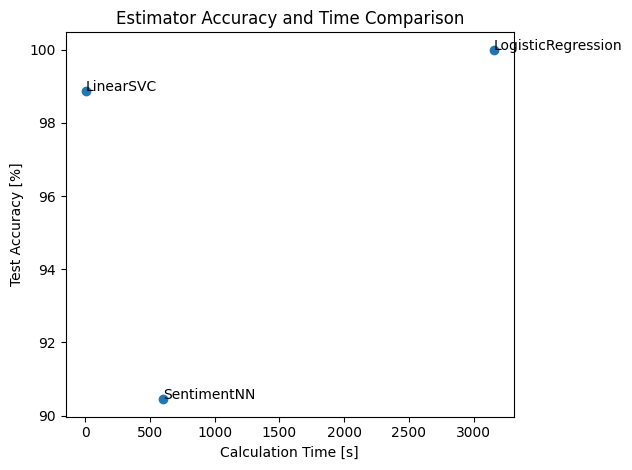

In [35]:
from matplotlib import pyplot as plt
# Plot datasets
est_labels = []
est_acc = []
est_time = []
# Print as table
print('''
============================================================
Estimator accuracy and time comparison
============================================================''')
for k, method in METHODS.items():
    print(f'''       Estimator: {method['est']}
       Accuracvy: {method['acc']*100:.1f} %
Calculation time: {method['time']:.1f} s
------------------------------------------------------------''')
    est_labels.append(k)
    est_acc.append(method['acc']*100)
    est_time.append(method['time'])
# Plot
plt.scatter(est_time, est_acc)
plt.xlabel('Calculation Time [s]')
plt.ylabel('Test Accuracy [%]')
plt.title('Estimator Accuracy and Time Comparison')
for i, txt in enumerate(est_time):
    plt.annotate(est_labels[i], (est_time[i], est_acc[i]))
plt.tight_layout()